## Reinforcement Learning Model of Emotional Conflict

This notebook models the behavioral data acquired from the Emotional Conflict Resolution (ECR) task/experiment <b>[1]</b> using the Rescorla Wagner model <b>[2]</b>. <br><br>

<b>[1]</b><i> Etkin et. al, 2006: https://doi.org/10.1016/j.neuron.2006.07.029 </i><br>
<b>[2]</b><i> Miller et. al, 1995: https://doi.org/10.1037/0033-2909.117.3.363 </i>

## Model - Equation

<center><b>Rescorla Wagner Model<br></b>
$\Delta V = \alpha\beta(\lambda - \Sigma V)$</center>

## Model - Parameters & Variables

| Variable | Description | Parameter Description | Parameter |
|:------:|:-----------:|:---------------------:|:---------:|
| $V$ | **current** associative value of the CS | ${\Delta V_1}$ --> ${\Delta V_2}$ --> ${\Delta V_3}$ | ${\Delta V_2}$ |
| $V_{-1}$| **previous** associative value of the CS | ------ | calculated |
| $V_{+1}$ | **new** associative value of the CS | ------ | calculated |
| $\Delta V$ | change in the associative value of $V$ | ------ | calculated |
| $\lambda -\Sigma V$ | surprise | ------ | calculated |
| $\Sigma V$ | sum of CS instances thus far | ------ | calculated |
| $\lambda$ | max associative value of CS | use 100 to scale as % | 100 |
|$\alpha$ | CS salience | 0 - 1, latent to highly salient | 0.5 |
|$\beta$ | US learning rate parameter | 0 - 1, doesn't change shape of curve | 0.2 |

## Experiment - Data Dictionary

The following table includes the data acquired during the ECR experiment (`Variable`) and the respective response codings (`Description`):<br><br>

| Variable | Description |
|----------|------------:|
| **ResponseOnset** | Onset time of response (seconds, 0 to 1)|
| **ResponseTime** | Length of response (seconds, 0 to 1)|
| **ResponseAccuracy** | 1 = Correct <br> 0 = Incorrect <br> 99 = no response (within 1s limit) |
| **ResponseUncertainty** | Matlab confidence bounds in <br> recording response time |
| **Conflict** | 0 = No conflict <br> 1 = incongruent → congruent <br> 2 = congruent → incongruent <br> 3 = incongruent → incongruent |
| **Valence** | 0 = NaN <br> 1 = Fearful <br> 2 = Happy |

## Import Libraries

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate
import sklearn.linear_model
from __future__ import division

## Run Reinforcement Learning Model + Visualize

In [9]:
def RW_model_visualize(frame, condition_type, subj_input):

        ##-- SET model constants
        V, sigmaV, lambd, alpha, beta, betas = [], 0, 100, 1, 0.01, np.linspace(.1,1,num=10)
        
        ##-- COMPUTE deltaV
        ##-- deltaV = change in association value of the CS
        ##-- sigmaV = updated association value

        for t in frame['Condition']:
            deltaV = alpha*(beta)*(lambd-sigmaV)
            V.append(deltaV)
            sigmaV=deltaV+sigmaV

        ##-- SAVE deltaV values
        frame['Predicted Value']=V
            
        ##-- PLOT all conditions: RT vs deltaV 
        if condition_type == "ALL":
            color_cond = "green"
            i = sns.jointplot(data=frame, x="Predicted Value", y="Reaction Time", palette='tab10', \
                              hue="Condition")
            i.plot_joint(sns.kdeplot, zorder=0, levels=6)
            i.plot_marginals(sns.rugplot, height=-.14, clip_on=False)
            i.fig.suptitle("%s | CONGRUENT & INCONGRUENT | RT vs ΔCS Association" % subj_input, y=1.03) # y= some height>1
            plt.show()
        
        ##-- PLOT each condition: RT vs deltaV 
        else:
            if condition_type == "CONGRUENT":
                color_cond = "b"
            elif condition_type == "INCONGRUENT":
                color_cond = "orange" 
            else:
                print("specify condition")
            
            k = sns.jointplot(x='Predicted Value', y='Reaction Time', data=frame, kind="reg", color=color_cond)
            k.fig.suptitle("%s | %s | RT vs ΔCS Association" % (subj_input,condition_type), y=1.03)
            plt.show()
    
        return

In [10]:
def parse_conditions(subject_sample):
    
    for subject in subject_sample:

        sns.set_style("darkgrid")

        ##-- LOAD data ----##
        df = pd.read_csv(os.path.join(path,'%s' % subject), index_col=None)
        df = pd.DataFrame(df)
        df = pd.DataFrame.dropna(df)
        df['Reaction Time'] = df['ResponseTime']

        SUBJ = subject[:5].upper()

        ##-- PARSE Congruent and Incongruent trials into separate dfs

        I_cond=[]
        I_rt=[]

        C_cond=[]
        C_rt=[]

        for c,r in zip(df['Condition'], df['Reaction Time']):
            if c==2:
                I_cond.append(c)
                I_rt.append(r)
            elif c==1:
                C_cond.append(c)
                C_rt.append(r)
            else:
                continue

        df_I=pd.DataFrame({'Condition':I_cond, 'Reaction Time':I_rt})
        df_C=pd.DataFrame({'Condition':C_cond, 'Reaction Time':C_rt})

        #---- RUN model for each condition ----##
        
        RW_model_visualize(df_I,"INCONGRUENT",SUBJ)
        RW_model_visualize(df_C,"CONGRUENT",SUBJ)
        RW_model_visualize(df,"ALL",SUBJ)
    
    return

## Example Output

For this subject, there are two key observations that can be made:
- The reaction time for "conflicting" trials (incongruent) is biased towards longer response times, as expected
- However, the change in association values across and between trials is approximately the same for both conditions, as evidenced by the similar distributions
- These results suggest that incorperating reaction time into the model may be more informative than the condition alone. Testing this hypothesis is warranted

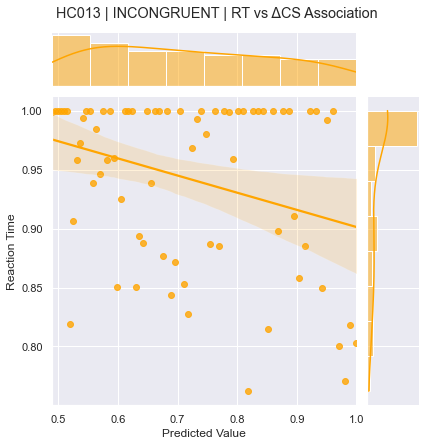

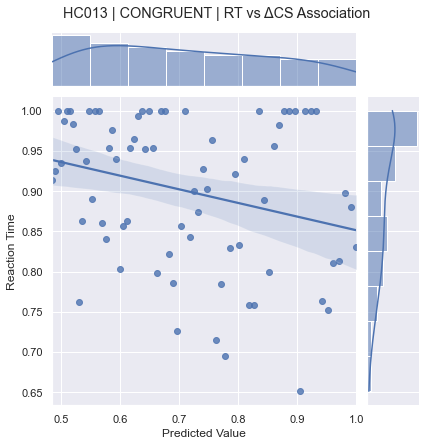

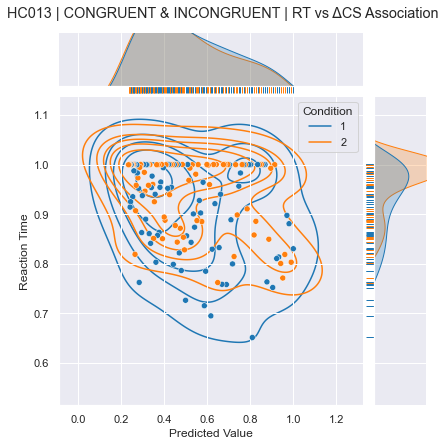

In [11]:
parse_conditions(subjlist[18:19])

## Experiment - Conditions

The task conditions are depicted as follows. See Etkin et. al for explicit definitions of variables (i.e. incongruent, congruent, conflict resolution)

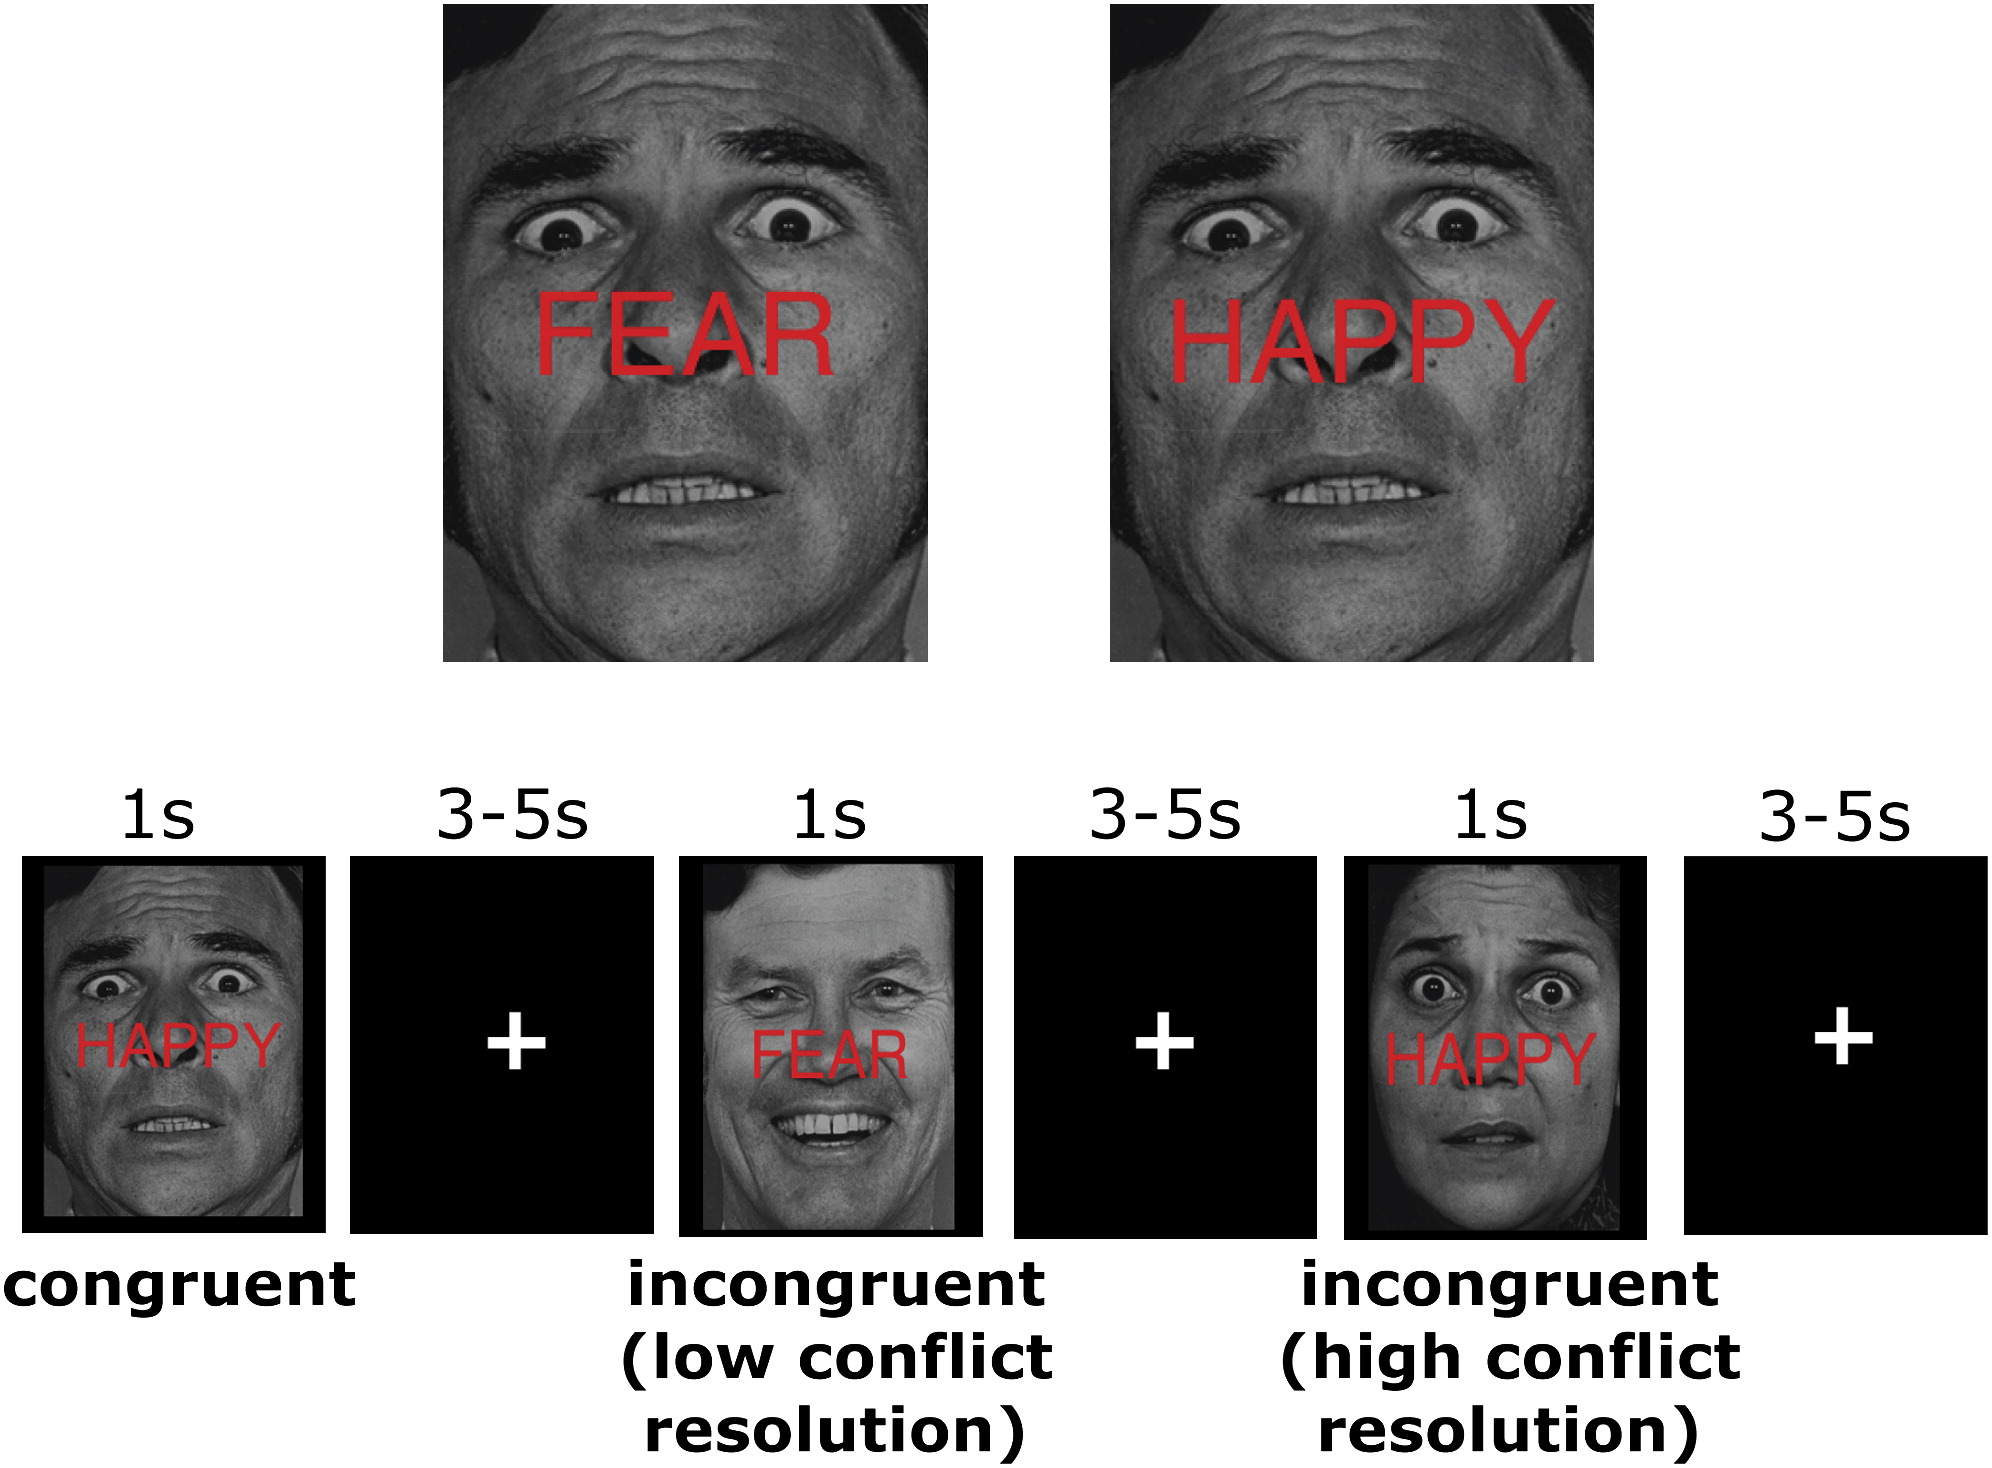

In [1]:
from IPython.display import Image
Image(filename='ecr_task.jpg') 